In [3]:
import psycopg2
# to install from commandline: conda install -c anaconda psycopg2
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)


In [5]:
#need to be connected to vpn
# note, all server information is stored in a config.py file 
import config 
conn = psycopg2.connect(dbname=config.dbname, user=config.user, host=config.host, port=config.port,password=config.password)
cur=conn.cursor()

query_schema = 'SET search_path to ' + "mimiciv" + ';'

How do other papers find pneumonia in MIMIC?

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8280627/ - VAP in MIMIC - methods unclear

https://journals.lww.com/md-journal/Fulltext/2021/06110/Predicting_ventilator_associated_pneumonia_with.36.aspx " (ICD) Revision 9 code 997.31 was the gold standard definition of VAP."

Where do ICD codes live? 
https://github.com/3778/icd-prediction-mimic
https://github.com/jamesmullenbach/caml-mimic



In [8]:
# join icd codes with dimensions to get the name of the icd codes

sql = query_schema + """
SELECT *
from mimiciv.diagnoses_icd dx
join mimiciv.d_icd_diagnoses icd
    on dx.icd_code=icd.icd_code
limit 5
"""
df = pd.read_sql_query(sql,conn) 
df


,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,15734973,20475282,3,2825,9,2825,9,Sickle-cell trait
1,15734973,20475282,2,V0251,9,V0251,9,Carrier or suspected carrier of group B strept...
2,15734973,20475282,5,V270,9,V270,9,"Outcome of delivery, single liveborn"
3,15734973,20475282,5,V270,9,V270,10,Motorcycle driver injured in collision with fi...
4,15734973,20475282,1,64891,9,64891,9,Other current conditions classifiable elsewher...


In [14]:
# join icd codes with dimensions to get the name of the icd codes
#search for pneumonia in the name

sql = query_schema + """
SELECT *
from mimiciv.diagnoses_icd dx
join mimiciv.d_icd_diagnoses icd
    on dx.icd_code=icd.icd_code
where icd.long_title LIKE '%pneumonia%'
limit 5
"""
df = pd.read_sql_query(sql,conn) 
df

#icd9 480-488  Pneumonia And Influenza

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,12615486,22971263,5,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
1,11383042,24135826,11,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
2,16327683,24544838,3,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
3,16087867,22710718,10,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
4,16625434,25780525,14,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae


In [104]:
# join icd codes with dimensions to get the name of the icd codes
#search for pneumonia in the name
#remove limit 
#icd9 480-488  Pneumonia And Influenza

sql = query_schema + """
SELECT *
from mimiciv.diagnoses_icd dx
join mimiciv.d_icd_diagnoses icd
    on dx.icd_code=icd.icd_code
where icd.long_title LIKE '%pneumonia%'
"""
df = pd.read_sql_query(sql,conn) 
df

#mixture of icd 9 and 10 but seems to capture a good number of patients 

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,11383042,24135826,11,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
1,16327683,24544838,3,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
2,16087867,22710718,10,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
3,16625434,25780525,14,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
4,16209708,28071945,2,481,9,481,9,Pneumococcal pneumonia [Streptococcus pneumoni...
...,...,...,...,...,...,...,...,...
10668,16525331,20803309,9,J188,10,J188,10,"Other pneumonia, unspecified organism"
10669,18115365,29229210,1,J188,10,J188,10,"Other pneumonia, unspecified organism"
10670,16664099,21037949,1,J1000,10,J1000,10,Influenza due to other identified influenza vi...
10671,16050305,29914393,1,J129,10,J129,10,"Viral pneumonia, unspecified"


In [17]:
df.to_csv("mimiciv-pneumonia-icd-names2-12-22.csv")

In [50]:
len(df.subject_id.unique())

8584

In [51]:
len(df.hadm_id.unique())

9999

In [52]:
len(df.icd_code.unique())

AttributeError: 'DataFrame' object has no attribute 'unique'

In [53]:
(df['icd_code'].nunique())

icd_code    69
icd_code    69
dtype: int64

In [54]:
df.columns

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version',
       'icd_code', 'icd_version', 'long_title'],
      dtype='object')

In [68]:
df.dtypes

subject_id      int64
hadm_id         int64
seq_num         int64
icd_code       object
icd_version     int64
icd_code       object
icd_version     int64
long_title     object
dtype: object

In [69]:
df.long_title.value_counts()

Ventilator associated pneumonia                                                                                           1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                                       1425
Personal history of pneumonia (recurrent)                                                                                 1208
Bacterial pneumonia, unspecified                                                                                          1093
Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
                                                                                                                          ... 
Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture       1
Tuberculous pneumonia [any form], unspecified                                                                  

In [76]:
#what does a single admission's pneumonia icd codes look like?
df[df['hadm_id']==25780525]

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
10672,12615486,22971263,5,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...


In [78]:
df[df['hadm_id']==25780525]

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
3,16625434,25780525,14,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae


In [88]:
df2 = df #oops, did weird equal thing, messed up why is it adding b to everything? 

In [93]:
df2['long_title']=df2['long_title'].astype('|S') 

In [83]:
df2.group_by('icd_code').value_counts()

AttributeError: 'DataFrame' object has no attribute 'group_by'

In [95]:
df2.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,11383042,24135826,11,b'4820',9,b'4820',9,b'Pneumonia due to Klebsiella pneumoniae'
1,16327683,24544838,3,b'48241',9,b'48241',9,b'Methicillin susceptible pneumonia due to Sta...
2,16087867,22710718,10,b'48241',9,b'48241',9,b'Methicillin susceptible pneumonia due to Sta...
3,16625434,25780525,14,b'4820',9,b'4820',9,b'Pneumonia due to Klebsiella pneumoniae'
4,16209708,28071945,2,b'481',9,b'481',9,b'Pneumococcal pneumonia [Streptococcus pneumo...


In [96]:
df.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,11383042,24135826,11,b'4820',9,b'4820',9,b'Pneumonia due to Klebsiella pneumoniae'
1,16327683,24544838,3,b'48241',9,b'48241',9,b'Methicillin susceptible pneumonia due to Sta...
2,16087867,22710718,10,b'48241',9,b'48241',9,b'Methicillin susceptible pneumonia due to Sta...
3,16625434,25780525,14,b'4820',9,b'4820',9,b'Pneumonia due to Klebsiella pneumoniae'
4,16209708,28071945,2,b'481',9,b'481',9,b'Pneumococcal pneumonia [Streptococcus pneumo...


In [97]:
df.dtypes

subject_id     int64
hadm_id        int64
seq_num        int64
icd_code         |S6
icd_version    int64
icd_code         |S6
icd_version    int64
long_title     |S118
dtype: object

In [100]:
df2['long_title']=df2['long_title'].astype('str') 

In [101]:
df2.dtypes

subject_id      int64
hadm_id         int64
seq_num         int64
icd_code          |S6
icd_version     int64
icd_code          |S6
icd_version     int64
long_title     object
dtype: object

In [103]:
df2.groupby('icd_code').value_counts()

ValueError: Grouper for 'icd_code' not 1-dimensional

In [105]:
df2 = df.copy()

In [106]:
df2

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,11383042,24135826,11,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
1,16327683,24544838,3,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
2,16087867,22710718,10,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
3,16625434,25780525,14,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
4,16209708,28071945,2,481,9,481,9,Pneumococcal pneumonia [Streptococcus pneumoni...
...,...,...,...,...,...,...,...,...
10668,16525331,20803309,9,J188,10,J188,10,"Other pneumonia, unspecified organism"
10669,18115365,29229210,1,J188,10,J188,10,"Other pneumonia, unspecified organism"
10670,16664099,21037949,1,J1000,10,J1000,10,Influenza due to other identified influenza vi...
10671,16050305,29914393,1,J129,10,J129,10,"Viral pneumonia, unspecified"


In [110]:
df2.long_title.value_counts()

Ventilator associated pneumonia                                                                                           1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                                       1425
Personal history of pneumonia (recurrent)                                                                                 1208
Bacterial pneumonia, unspecified                                                                                          1093
Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
                                                                                                                          ... 
Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture       1
Tuberculous pneumonia [any form], unspecified                                                                  

In [112]:
pd.set_option("display.max_rows", None)

In [113]:
df2.long_title.value_counts()

Ventilator associated pneumonia                                                                                           1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere                                       1425
Personal history of pneumonia (recurrent)                                                                                 1208
Bacterial pneumonia, unspecified                                                                                          1093
Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
Unspecified bacterial pneumonia                                                                                            716
Methicillin resistant pneumonia due to Staphylococcus aureus                                                               346
Methicillin susceptible pneumonia due to Staphylococcus aureus                                                 

<AxesSubplot:ylabel='Frequency'>

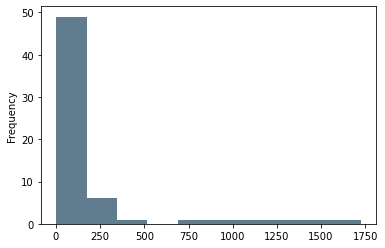

In [111]:
df2.long_title.value_counts().plot.hist(grid=False,
                   color='#607c8e')

- ICD codes that should probably get removed 

Other specified vaccinations against streptococcus pneumoniae [pneumococcus]                                              1007
Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza            338
Cryptogenic organizing pneumonia                                                                                           125
Congenital pneumonia                                                                                                        38
Abscess of lung without pneumonia                                                                                           32

- what about this one?
Personal history of pneumonia (recurrent)                                                                                 1208

- and should probably remove a bunch of these with <10 results

Congenital pneumonia, unspecified                                                                                           10
Congenital pneumonia due to staphylococcus                                                                                   7
Idiopathic interstitial pneumonia, not otherwise specified                                                                   6
Congenital pneumonia due to other bacterial agents                                                                           5
Desquamative interstitial pneumonia                                                                                          4
Congenital pneumonia due to Escherichia coli                                                                                 3
Infection by Histoplasma capsulatum, pneumonia                                                                               2
Tuberculous pneumonia [any form], tubercle bacilli found (in sputum) by microscopy                                           2
Whooping cough, unspecified species without pneumonia                                                                        2
Congenital pneumonia due to Pseudomonas                                                                                      1
Congenital pneumonia due to viral agent                                                                                      1
Hypostatic pneumonia, unspecified organism                                                                                   1
Salmonella pneumonia                                                                                                         1
Lymphoid interstitial pneumonia                                                                                              1
Congenital pneumonia due to streptococcus, group B                                                                           1
Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture       1
Tuberculous pneumonia [any form], unspecified                                                                                1
Influenza due to identified 2009 H1N1 influenza virus with pneumonia                                                         1
Idiopathic lymphoid interstitial pneumonia                                                                                   1
Varicella pneumonia                                                                                                          1

In [114]:
names_to_remove = [
    'Other specified vaccinations against streptococcus pneumoniae [pneumococcus]',
    'Need for prophylactic vaccination and inoculation against streptococcus pneumoniae [pneumococcus] and influenza',
    'Cryptogenic organizing pneumonia',
    'Congenital pneumonia',
    'Abscess of lung without pneumonia'  
]

In [115]:
df3 = df2[~df2['long_title'].isin(names_to_remove)]

In [122]:
df3.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version,icd_code,icd_version,long_title
0,11383042,24135826,11,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
1,16327683,24544838,3,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
2,16087867,22710718,10,48241,9,48241,9,Methicillin susceptible pneumonia due to Staph...
3,16625434,25780525,14,4820,9,4820,9,Pneumonia due to Klebsiella pneumoniae
4,16209708,28071945,2,481,9,481,9,Pneumococcal pneumonia [Streptococcus pneumoni...


In [126]:
pd.set_option("display.max_rows", 10)

In [127]:
df3.long_title.value_counts()

Ventilator associated pneumonia                                                        1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere    1425
Personal history of pneumonia (recurrent)                                              1208
Bacterial pneumonia, unspecified                                                       1093
Unspecified bacterial pneumonia                                                         716
                                                                                       ... 
Salmonella pneumonia                                                                      1
Idiopathic lymphoid interstitial pneumonia                                                1
Influenza due to identified 2009 H1N1 influenza virus with pneumonia                      1
Tuberculous pneumonia [any form], unspecified                                             1
Varicella pneumonia                                                             

In [129]:
additional_to_remove = [
    'Congenital pneumonia, unspecified',
    'Congenital pneumonia due to staphylococcus',
    'Idiopathic interstitial pneumonia, not otherwise specified',
    'Congenital pneumonia due to other bacterial agents',
    'Desquamative interstitial pneumonia',
    'Congenital pneumonia due to Escherichia coli',
    'Infection by Histoplasma capsulatum, pneumonia',
    'Tuberculous pneumonia [any form], tubercle bacilli found (in sputum) by microscopy',
    'Whooping cough, unspecified species without pneumonia',
    'Congenital pneumonia due to Pseudomonas',
    'Congenital pneumonia due to viral agent',
    'Hypostatic pneumonia, unspecified organism',
    'Lymphoid interstitial pneumonia',
    'Congenital pneumonia due to streptococcus, group B',
    'Tuberculous pneumonia [any form], tubercle bacilli not found (in sputum) by microscopy, but found by bacterial culture',
    'Tuberculous pneumonia [any form], unspecified',  
    'Idiopathic lymphoid interstitial pneumonia'
]


In [132]:
df3 = df3[~df3['long_title'].isin(additional_to_remove)]

In [133]:
df3.long_title.value_counts()

Ventilator associated pneumonia                                                        1723
Klebsiella pneumoniae [K. pneumoniae] as the cause of diseases classified elsewhere    1425
Personal history of pneumonia (recurrent)                                              1208
Bacterial pneumonia, unspecified                                                       1093
Unspecified bacterial pneumonia                                                         716
                                                                                       ... 
Human metapneumovirus pneumonia                                                           3
Adenoviral pneumonia                                                                      3
Salmonella pneumonia                                                                      1
Influenza due to identified 2009 H1N1 influenza virus with pneumonia                      1
Varicella pneumonia                                                             

In [135]:
len(df3.hadm_id.unique())

8459

In [134]:
df3.to_csv("pneumonia_cases_clean2-12-22.csv")